In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [2]:
! pip install torch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
!pip install -q transformers flash_attn timm einops peft

In [4]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
#import supervision as sv

#from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
#from roboflow import Roboflow

/tmp/ipykernel_22/1696402682.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

model_id = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
#!unzip /content/dataset.zip

In [7]:
# @title Define `CaptioningDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class CaptioningDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = "<MORE_DETAILED_CAPTION>"
        suffix = data['suffix']
        return prefix, suffix, image

In [8]:
# @title Initiate `CaptioningDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 2
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = CaptioningDataset(
    jsonl_file_path = "/kaggle/input/augmenteddataset/train/preprocessed_train.jsonl",
    image_directory_path = "/kaggle/input/augmenteddataset/train"
)
val_dataset = CaptioningDataset(
    jsonl_file_path = "/kaggle/input/augmenteddataset/valid/preprocessed_valid.jsonl",
    image_directory_path = "/kaggle/input/augmenteddataset/valid"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [9]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.5,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [10]:
torch.cuda.empty_cache()

In [11]:
model = model.to(torch.float32)


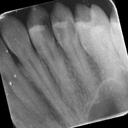
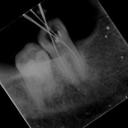
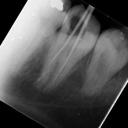
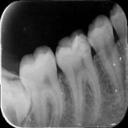

In [12]:
from PIL import Image
import io
import base64
import json
import html
from IPython.display import display, HTML

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image = image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image: Image.Image, caption: str):
    """Render image and caption as HTML."""
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

def render_inference_results(model, dataset: CaptioningDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = "<MORE_DETAILED_CAPTION>"
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        caption = generated_text.strip()  # Process and clean up the generated text
        html_out += render_example(image, caption)

    display(HTML(html_out))

# Run the updated function to display image captions
render_inference_results(peft_model, val_dataset, 4)


In [13]:
import os
import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AdamW, get_scheduler

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Initialize GradScaler for mixed precision training
    scaler = GradScaler()

    # Lists to store losses
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids = inputs["input_ids"].to(DEVICE)
            pixel_values = inputs["pixel_values"].to(DEVICE)
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                truncation=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            # Mixed precision training
            with autocast():
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()

            train_loss += loss.item()

            # Clear GPU cache
            torch.cuda.empty_cache()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}: Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                input_ids = inputs["input_ids"].to(DEVICE)
                pixel_values = inputs["pixel_values"].to(DEVICE)
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch + 1}: Average Validation Loss: {avg_val_loss}")

            # Render inference results for validation data
            render_inference_results(model, val_loader.dataset, 6)

        # Save model and processor checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

    # Plot the loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.savefig('loss_curves.png')  # Save the plot as a PNG file
    plt.show()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_22/2081242548.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training Epoch 1/100:   0%|          | 0/161 [00:00<?, ?it/s]/tmp/ipykernel_22/2081242548.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1/100: 100%|██████████| 161/161 [02:16<00:00,  1.18it/s]


Epoch 1: Average Training Loss: 1.0844376522191563


Validation Epoch 1/100: 100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch 1: Average Validation Loss: 0.5683224342173809



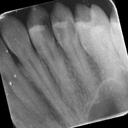
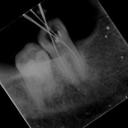
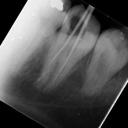
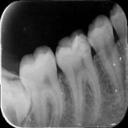
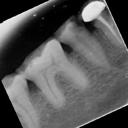
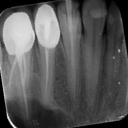

/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Training Epoch 2/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 2: Average Training Loss: 0.6160881147251366


Validation Epoch 2/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 2: Average Validation Loss: 0.4719012954252229



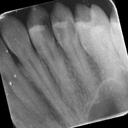
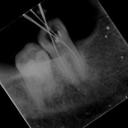
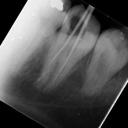
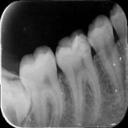
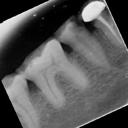
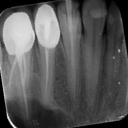

Training Epoch 3/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 3: Average Training Loss: 0.5405081909450685


Validation Epoch 3/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 3: Average Validation Loss: 0.46059329183303194



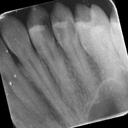
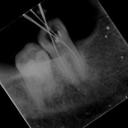
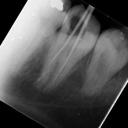
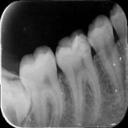
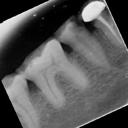
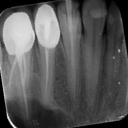

Training Epoch 4/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 4: Average Training Loss: 0.5259195792008631


Validation Epoch 4/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 4: Average Validation Loss: 0.45866141318202874



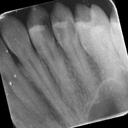
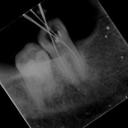
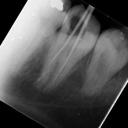
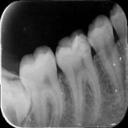
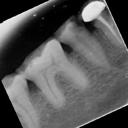
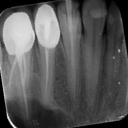

Training Epoch 5/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 5: Average Training Loss: 0.49754064928115527


Validation Epoch 5/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 5: Average Validation Loss: 0.43160371975504236



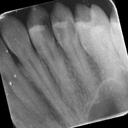
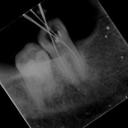
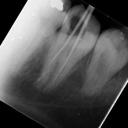
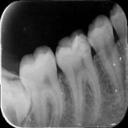
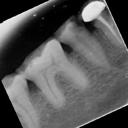
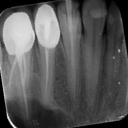

Training Epoch 6/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 6: Average Training Loss: 0.4632582246146587


Validation Epoch 6/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 6: Average Validation Loss: 0.3972958213776993



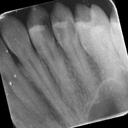
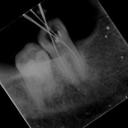
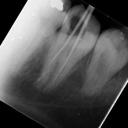
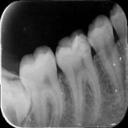
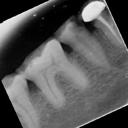
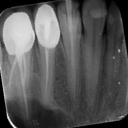

Training Epoch 7/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 7: Average Training Loss: 0.4170862371506898


Validation Epoch 7/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 7: Average Validation Loss: 0.3862001388300237



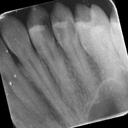
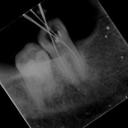
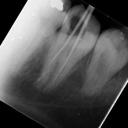
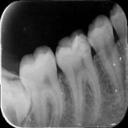
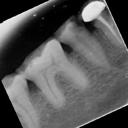
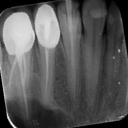

Training Epoch 8/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 8: Average Training Loss: 0.44588385351141047


Validation Epoch 8/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 8: Average Validation Loss: 0.40710484705490174



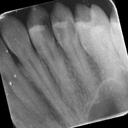
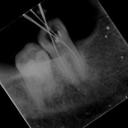
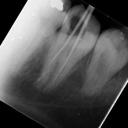
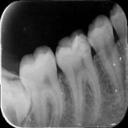
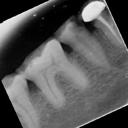
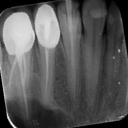

Training Epoch 9/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 9: Average Training Loss: 1.3449535921493672


Validation Epoch 9/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 9: Average Validation Loss: 0.5736341490376767



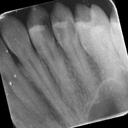
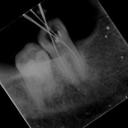
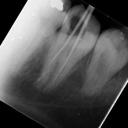
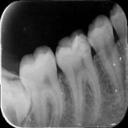
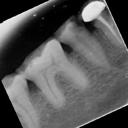
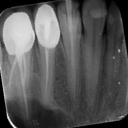

Training Epoch 10/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 10: Average Training Loss: 0.5878673256924434


Validation Epoch 10/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 10: Average Validation Loss: 0.44165119255403823



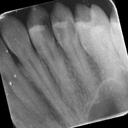
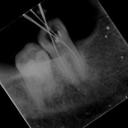
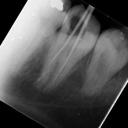
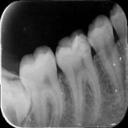
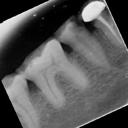
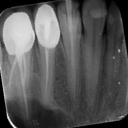

Training Epoch 11/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 11: Average Training Loss: 0.4539680874773434


Validation Epoch 11/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 11: Average Validation Loss: 0.4300343484865676



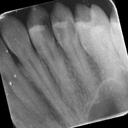
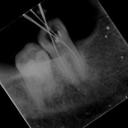
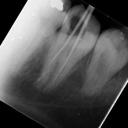
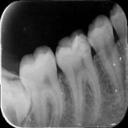
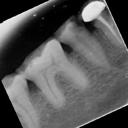
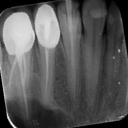

Training Epoch 12/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 12: Average Training Loss: 0.4214302877554242


Validation Epoch 12/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 12: Average Validation Loss: 0.41504473930640184



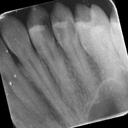
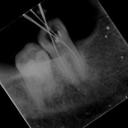
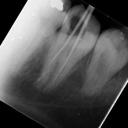
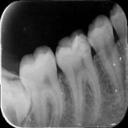
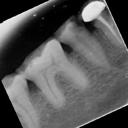
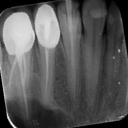

Training Epoch 13/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 13: Average Training Loss: 0.37012086068251115


Validation Epoch 13/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 13: Average Validation Loss: 0.3780139360121257



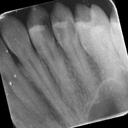
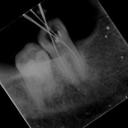
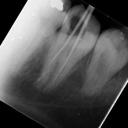
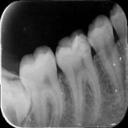
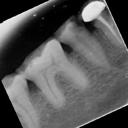
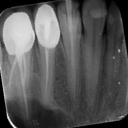

Training Epoch 14/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 14: Average Training Loss: 0.34756494197786225


Validation Epoch 14/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 14: Average Validation Loss: 0.3908270202684317



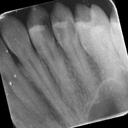
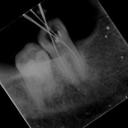
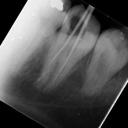
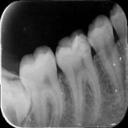
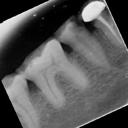
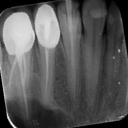

Training Epoch 15/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 15: Average Training Loss: 0.3377132023343388


Validation Epoch 15/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 15: Average Validation Loss: 0.37538627154535525



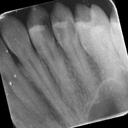
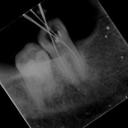
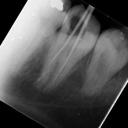
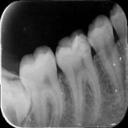
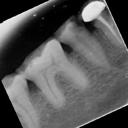
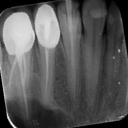

Training Epoch 16/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 16: Average Training Loss: 0.3138047451188105


Validation Epoch 16/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 16: Average Validation Loss: 0.3695118357862929



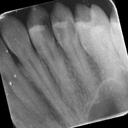
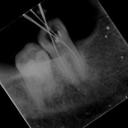
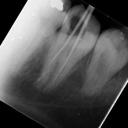
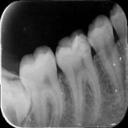
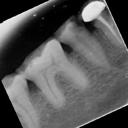
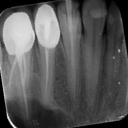

Training Epoch 17/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 17: Average Training Loss: 0.2983067063903957


Validation Epoch 17/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 17: Average Validation Loss: 0.38059701657981326



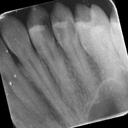
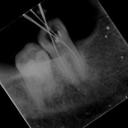
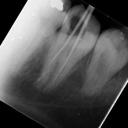
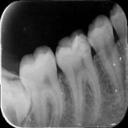
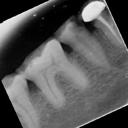
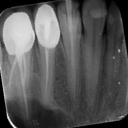

Training Epoch 18/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 18: Average Training Loss: 0.29036357496743614


Validation Epoch 18/100: 100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch 18: Average Validation Loss: 0.3373422839229913



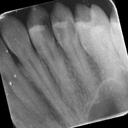
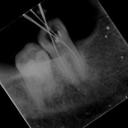
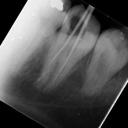
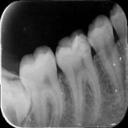
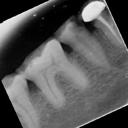
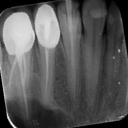

Training Epoch 19/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 19: Average Training Loss: 0.28433101890342577


Validation Epoch 19/100: 100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch 19: Average Validation Loss: 0.3457645908158889



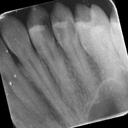
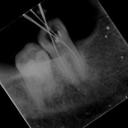
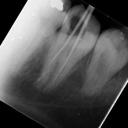
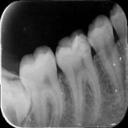
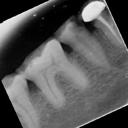
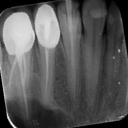

Training Epoch 20/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 20: Average Training Loss: 0.2781862333787154


Validation Epoch 20/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 20: Average Validation Loss: 0.359804854172168



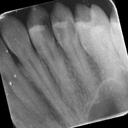
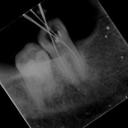
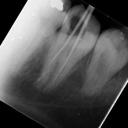
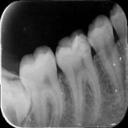
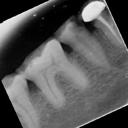
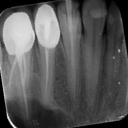

Training Epoch 21/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 21: Average Training Loss: 0.277580331525077


Validation Epoch 21/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 21: Average Validation Loss: 0.3455053786579654



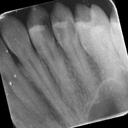
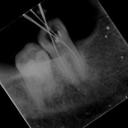
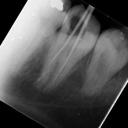
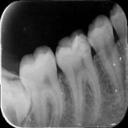
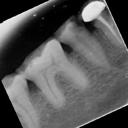
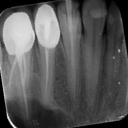

Training Epoch 22/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 22: Average Training Loss: 0.26300514167787864


Validation Epoch 22/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 22: Average Validation Loss: 0.3488356773373034



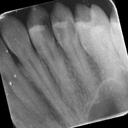
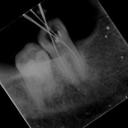
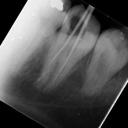
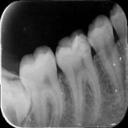
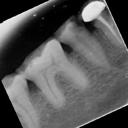
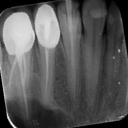

Training Epoch 23/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 23: Average Training Loss: 0.2726633725514323


Validation Epoch 23/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 23: Average Validation Loss: 0.34482899769175823



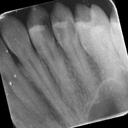
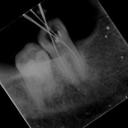
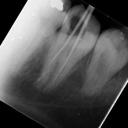
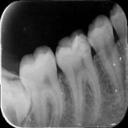
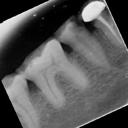
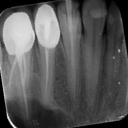

Training Epoch 24/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 24: Average Training Loss: 0.2681940027182887


Validation Epoch 24/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 24: Average Validation Loss: 0.3341393699105695



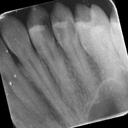
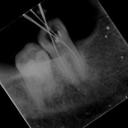
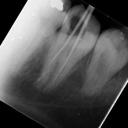
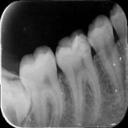
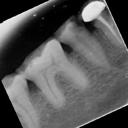
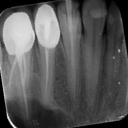

Training Epoch 25/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 25: Average Training Loss: 0.26541594054943285


Validation Epoch 25/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 25: Average Validation Loss: 0.3335592495880539



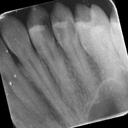
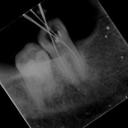
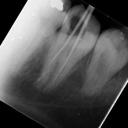
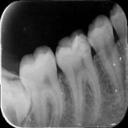
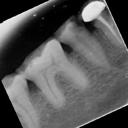
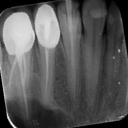

Training Epoch 26/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 26: Average Training Loss: 0.24488444448165272


Validation Epoch 26/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 26: Average Validation Loss: 0.33969862190939537



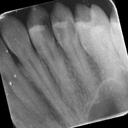
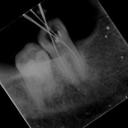
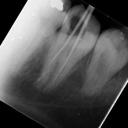
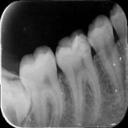
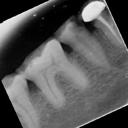
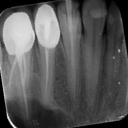

Training Epoch 27/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 27: Average Training Loss: 0.24798069126117303


Validation Epoch 27/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 27: Average Validation Loss: 0.3389634433463752



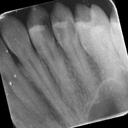
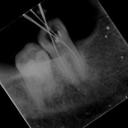
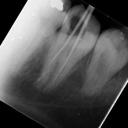
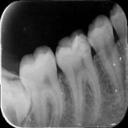
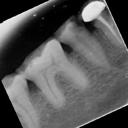
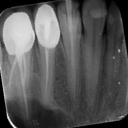

Training Epoch 28/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 28: Average Training Loss: 0.23142142054734763


Validation Epoch 28/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 28: Average Validation Loss: 0.3414928859649159



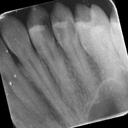
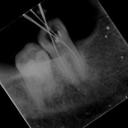
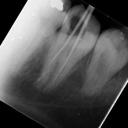
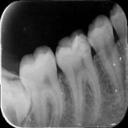
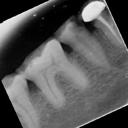
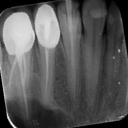

Training Epoch 29/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 29: Average Training Loss: 0.22975286221282082


Validation Epoch 29/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 29: Average Validation Loss: 0.31803872664090543



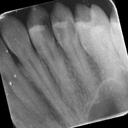
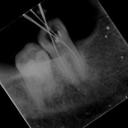
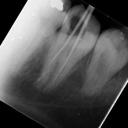
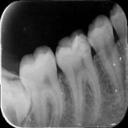
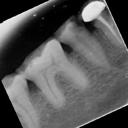
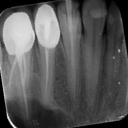

Training Epoch 30/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 30: Average Training Loss: 0.22764577388022997


Validation Epoch 30/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 30: Average Validation Loss: 0.33224423666544955



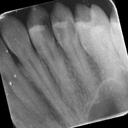
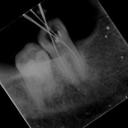
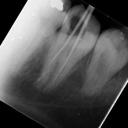
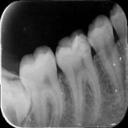
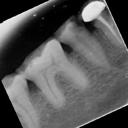
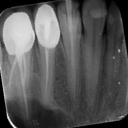

Training Epoch 31/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 31: Average Training Loss: 0.2152518086736987


Validation Epoch 31/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 31: Average Validation Loss: 0.33888361005367135



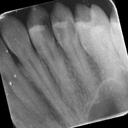
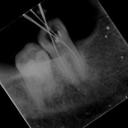
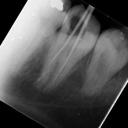
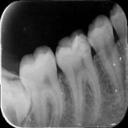
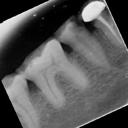
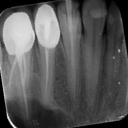

Training Epoch 32/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 32: Average Training Loss: 0.2126804225794647


Validation Epoch 32/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 32: Average Validation Loss: 0.3355136799136941



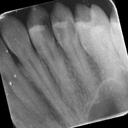
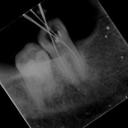
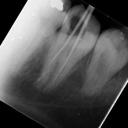
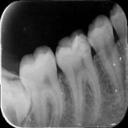
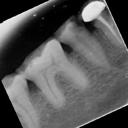
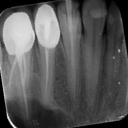

Training Epoch 33/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 33: Average Training Loss: 0.2209368546186767


Validation Epoch 33/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 33: Average Validation Loss: 0.3325774662411041



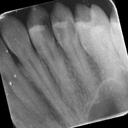
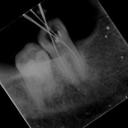
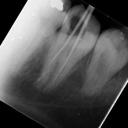
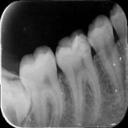
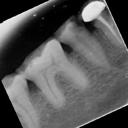
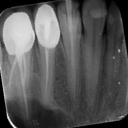

Training Epoch 34/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 34: Average Training Loss: 0.21388390868531992


Validation Epoch 34/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 34: Average Validation Loss: 0.331629308382813



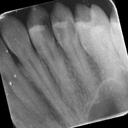
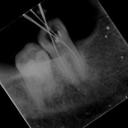
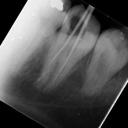
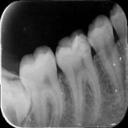
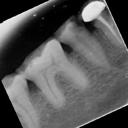
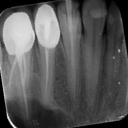

Training Epoch 35/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 35: Average Training Loss: 0.20290138077291642


Validation Epoch 35/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 35: Average Validation Loss: 0.32308297848208345



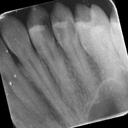
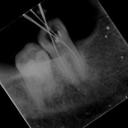
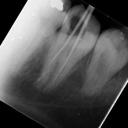
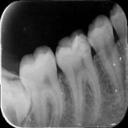
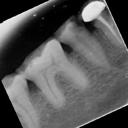
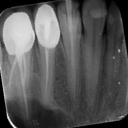

Training Epoch 36/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 36: Average Training Loss: 0.20440498857487063


Validation Epoch 36/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 36: Average Validation Loss: 0.32229088195901123



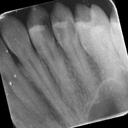
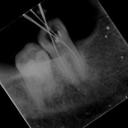
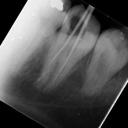
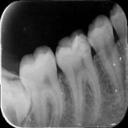
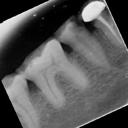
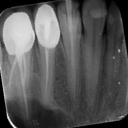

Training Epoch 37/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 37: Average Training Loss: 0.19755906944874652


Validation Epoch 37/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 37: Average Validation Loss: 0.3198586978393493



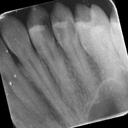
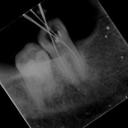
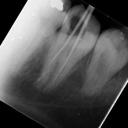
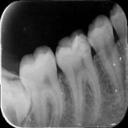
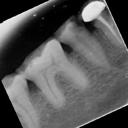
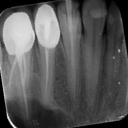

Training Epoch 38/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 38: Average Training Loss: 0.19575256703895813


Validation Epoch 38/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 38: Average Validation Loss: 0.3414724248749532



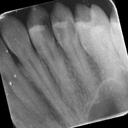
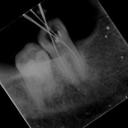
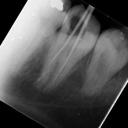
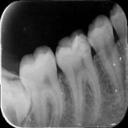
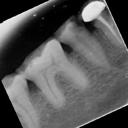
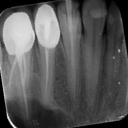

Training Epoch 39/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 39: Average Training Loss: 0.19354515336453915


Validation Epoch 39/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 39: Average Validation Loss: 0.31995575029483375



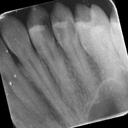
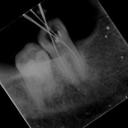
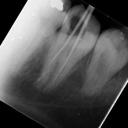
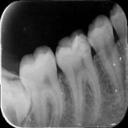
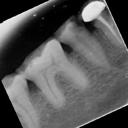
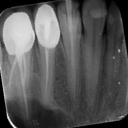

Training Epoch 40/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 40: Average Training Loss: 0.18380583200302925


Validation Epoch 40/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 40: Average Validation Loss: 0.31499857994185076



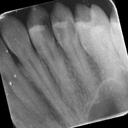
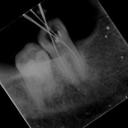
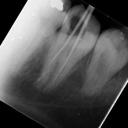
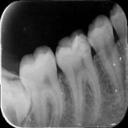
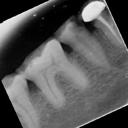
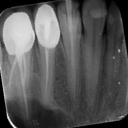

Training Epoch 41/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 41: Average Training Loss: 0.19490619674787757


Validation Epoch 41/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 41: Average Validation Loss: 0.31704312340497115



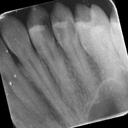
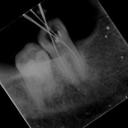
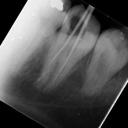
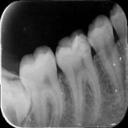
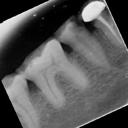
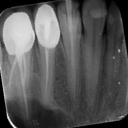

Training Epoch 42/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 42: Average Training Loss: 0.18655005081192308


Validation Epoch 42/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 42: Average Validation Loss: 0.32070826907916894



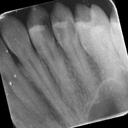
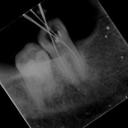
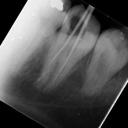
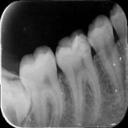
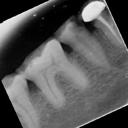
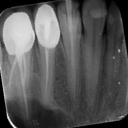

Training Epoch 43/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 43: Average Training Loss: 0.17797984115733123


Validation Epoch 43/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 43: Average Validation Loss: 0.312572388903057



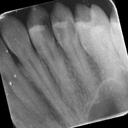
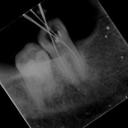
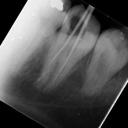
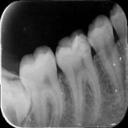
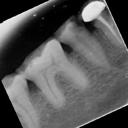
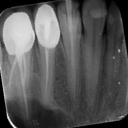

Training Epoch 44/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 44: Average Training Loss: 0.1790316857582664


Validation Epoch 44/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 44: Average Validation Loss: 0.3367269219656428



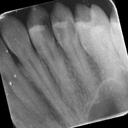
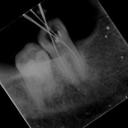
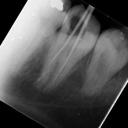
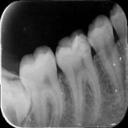
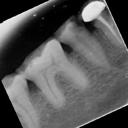
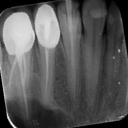

Training Epoch 45/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 45: Average Training Loss: 0.187197522508987


Validation Epoch 45/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 45: Average Validation Loss: 0.3238040035684332



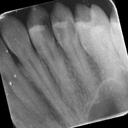
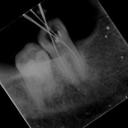
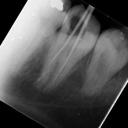
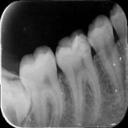
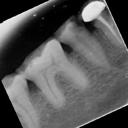
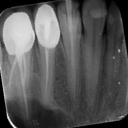

Training Epoch 46/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 46: Average Training Loss: 0.17447153039230323


Validation Epoch 46/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 46: Average Validation Loss: 0.31430126470681147



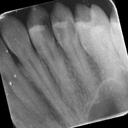
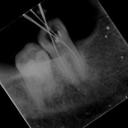
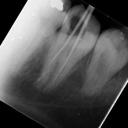
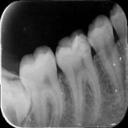
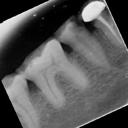
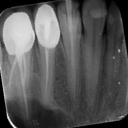

Training Epoch 47/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 47: Average Training Loss: 0.1671879374601456


Validation Epoch 47/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 47: Average Validation Loss: 0.3126209075529155



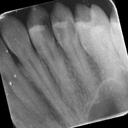
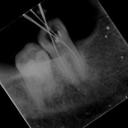
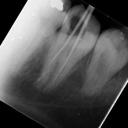
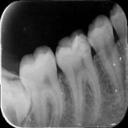
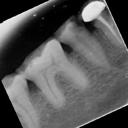
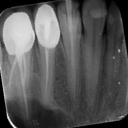

Training Epoch 48/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 48: Average Training Loss: 0.16877670535204572


Validation Epoch 48/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 48: Average Validation Loss: 0.31735295711232603



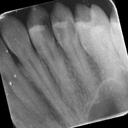
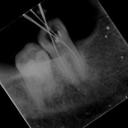
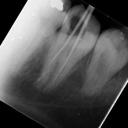
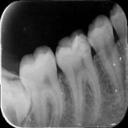
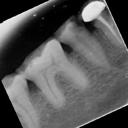
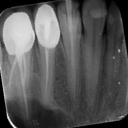

Training Epoch 49/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 49: Average Training Loss: 0.1733155334310502


Validation Epoch 49/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 49: Average Validation Loss: 0.33375763043546847



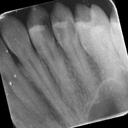
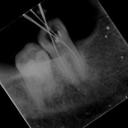
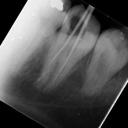
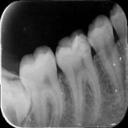
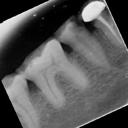
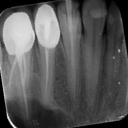

Training Epoch 50/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 50: Average Training Loss: 0.21301126977579193


Validation Epoch 50/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 50: Average Validation Loss: 0.3241304004256674



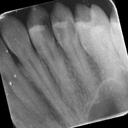
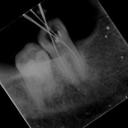
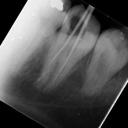
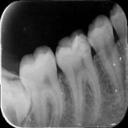
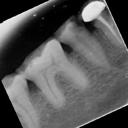
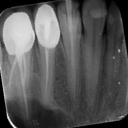

Training Epoch 51/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 51: Average Training Loss: 0.17127592796864716


Validation Epoch 51/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 51: Average Validation Loss: 0.3138328424299792



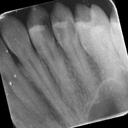
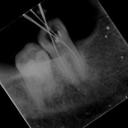
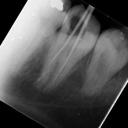
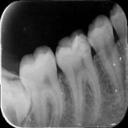
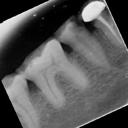
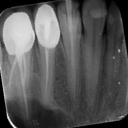

Training Epoch 52/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 52: Average Training Loss: 0.1605548509599074


Validation Epoch 52/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 52: Average Validation Loss: 0.3197721479353394



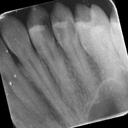
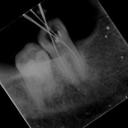
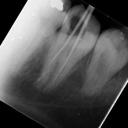
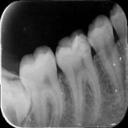
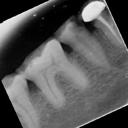
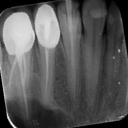

Training Epoch 53/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 53: Average Training Loss: 0.15696214400925992


Validation Epoch 53/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 53: Average Validation Loss: 0.3270197407402795



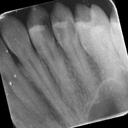
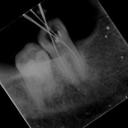
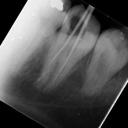
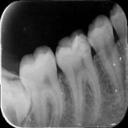
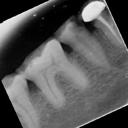
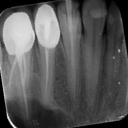

Training Epoch 54/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 54: Average Training Loss: 0.17093530547174607


Validation Epoch 54/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 54: Average Validation Loss: 0.30694797782482003



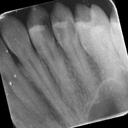
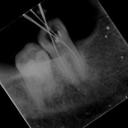
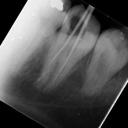
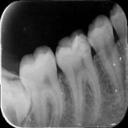
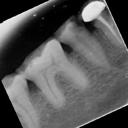
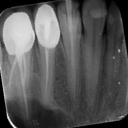

Training Epoch 55/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 55: Average Training Loss: 0.15512840061084085


Validation Epoch 55/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 55: Average Validation Loss: 0.30088082544183986



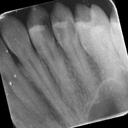
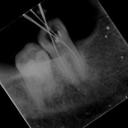
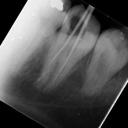
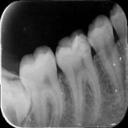
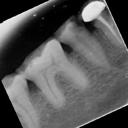
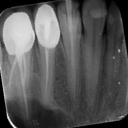

Training Epoch 56/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 56: Average Training Loss: 0.14614170713361746


Validation Epoch 56/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 56: Average Validation Loss: 0.31241332328201626



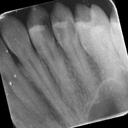
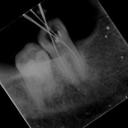
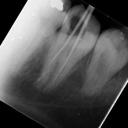
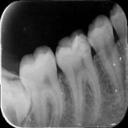
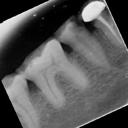
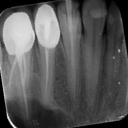

Training Epoch 57/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 57: Average Training Loss: 0.14274343029127357


Validation Epoch 57/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 57: Average Validation Loss: 0.3169819886977081



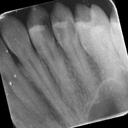
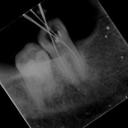
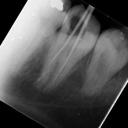
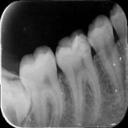
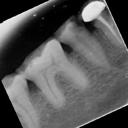
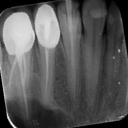

Training Epoch 58/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 58: Average Training Loss: 0.14317338150110304


Validation Epoch 58/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 58: Average Validation Loss: 0.3128142812215596



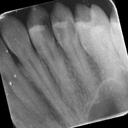
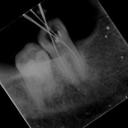
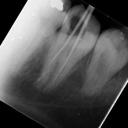
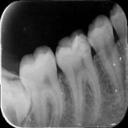
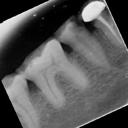
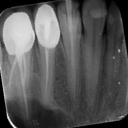

Training Epoch 59/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 59: Average Training Loss: 0.14034820785341057


Validation Epoch 59/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 59: Average Validation Loss: 0.3111183736205315



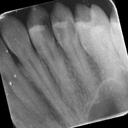
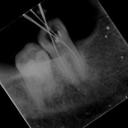
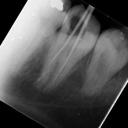
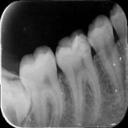
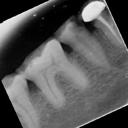
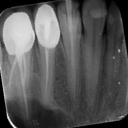

Training Epoch 60/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 60: Average Training Loss: 0.1386794332900773


Validation Epoch 60/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 60: Average Validation Loss: 0.30023791344849754



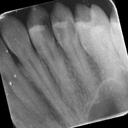
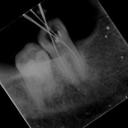
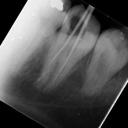
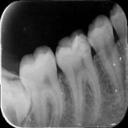
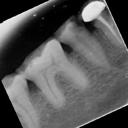
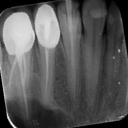

Training Epoch 61/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 61: Average Training Loss: 0.14017177921552096


Validation Epoch 61/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 61: Average Validation Loss: 0.305243584669108



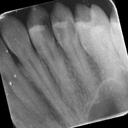
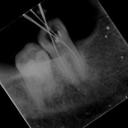
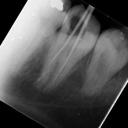
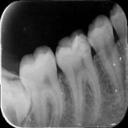
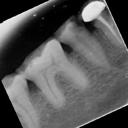
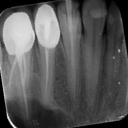

Training Epoch 62/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 62: Average Training Loss: 0.13316534879553762


Validation Epoch 62/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 62: Average Validation Loss: 0.3088020062435874



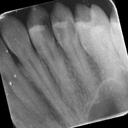
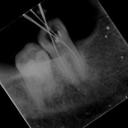
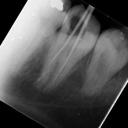
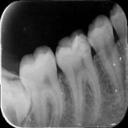
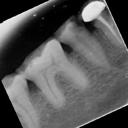
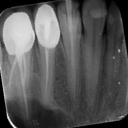

Training Epoch 63/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 63: Average Training Loss: 0.12618261328117447


Validation Epoch 63/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 63: Average Validation Loss: 0.3083068290926355



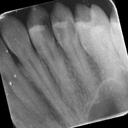
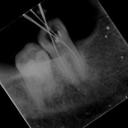
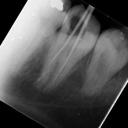
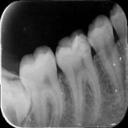
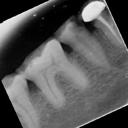
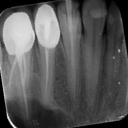

Training Epoch 64/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 64: Average Training Loss: 0.132382773418234


Validation Epoch 64/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 64: Average Validation Loss: 0.3175645573734701



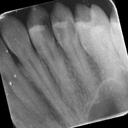
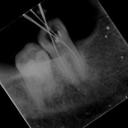
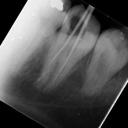
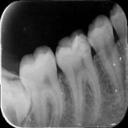
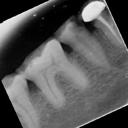
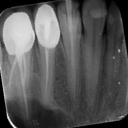

Training Epoch 65/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 65: Average Training Loss: 0.12959278765950144


Validation Epoch 65/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 65: Average Validation Loss: 0.30167382353876565



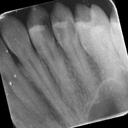
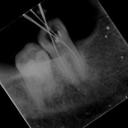
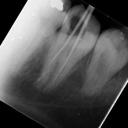
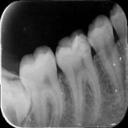
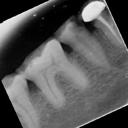
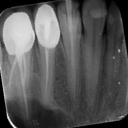

Training Epoch 66/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 66: Average Training Loss: 0.1324621292050951


Validation Epoch 66/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 66: Average Validation Loss: 0.307105538173974



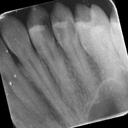
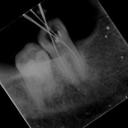
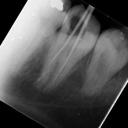
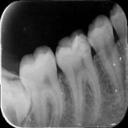
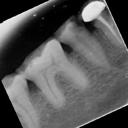
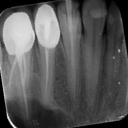

Training Epoch 67/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 67: Average Training Loss: 0.1317122594817825


Validation Epoch 67/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 67: Average Validation Loss: 0.3057914159039585



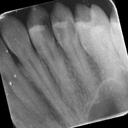
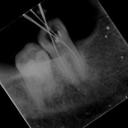
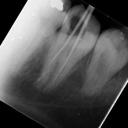
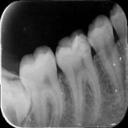
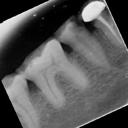
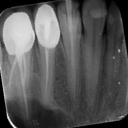

Training Epoch 68/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 68: Average Training Loss: 0.12617100967290978


Validation Epoch 68/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 68: Average Validation Loss: 0.31330565903201807



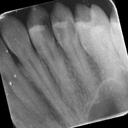
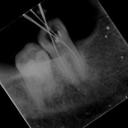
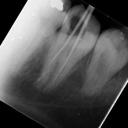
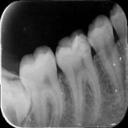
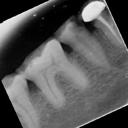
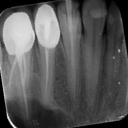

Training Epoch 69/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 69: Average Training Loss: 0.12026564179925445


Validation Epoch 69/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 69: Average Validation Loss: 0.30818668785069486



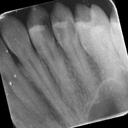
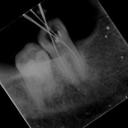
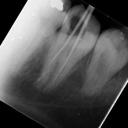
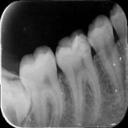
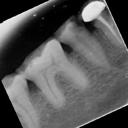
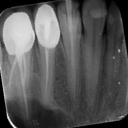

Training Epoch 70/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 70: Average Training Loss: 0.11767745233192947


Validation Epoch 70/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 70: Average Validation Loss: 0.30552006830468026



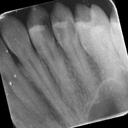
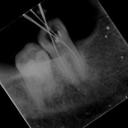
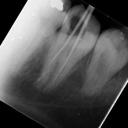
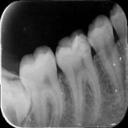
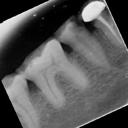
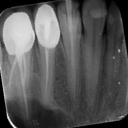

Training Epoch 71/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 71: Average Training Loss: 0.1191936692697291


Validation Epoch 71/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 71: Average Validation Loss: 0.3069802165674649



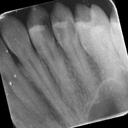
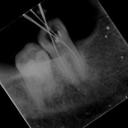
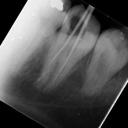
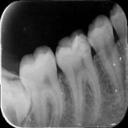
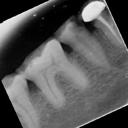
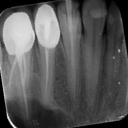

Training Epoch 72/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 72: Average Training Loss: 0.11570136591514445


Validation Epoch 72/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 72: Average Validation Loss: 0.3055578660782721



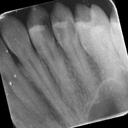
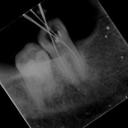
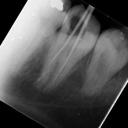
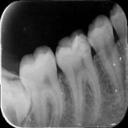
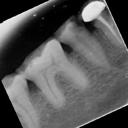
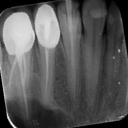

Training Epoch 73/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 73: Average Training Loss: 0.11833338446406104


Validation Epoch 73/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 73: Average Validation Loss: 0.3062978041820603



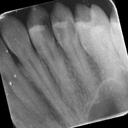
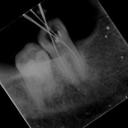
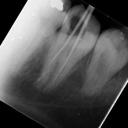
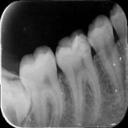
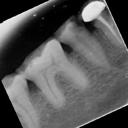
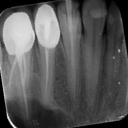

Training Epoch 74/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 74: Average Training Loss: 0.1078332127505763


Validation Epoch 74/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 74: Average Validation Loss: 0.3023975714773154



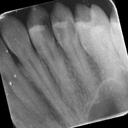
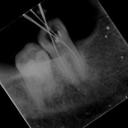
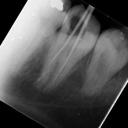
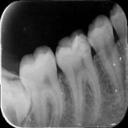
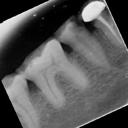
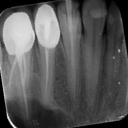

Training Epoch 75/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 75: Average Training Loss: 0.11195259544743884


Validation Epoch 75/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 75: Average Validation Loss: 0.30093557082063005



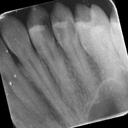
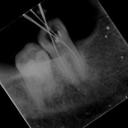
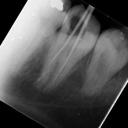
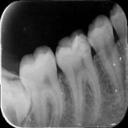
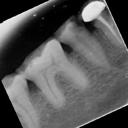
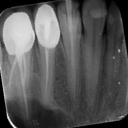

Training Epoch 76/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 76: Average Training Loss: 0.11325110499718175


Validation Epoch 76/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 76: Average Validation Loss: 0.29913939226070324



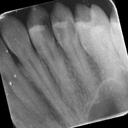
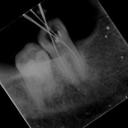
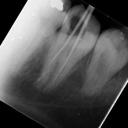
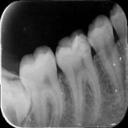
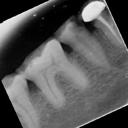
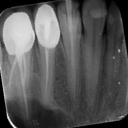

Training Epoch 77/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 77: Average Training Loss: 0.10601628074272079


Validation Epoch 77/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 77: Average Validation Loss: 0.2944411294762608



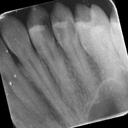
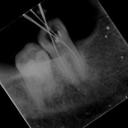
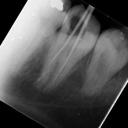
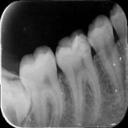
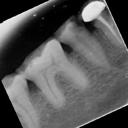
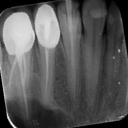

Training Epoch 78/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 78: Average Training Loss: 0.10732275782072026


Validation Epoch 78/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 78: Average Validation Loss: 0.299898815307793



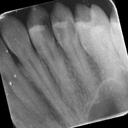
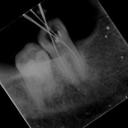
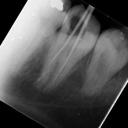
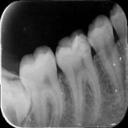
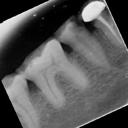
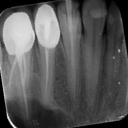

Training Epoch 79/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 79: Average Training Loss: 0.10610701926978108


Validation Epoch 79/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 79: Average Validation Loss: 0.3024701437638175



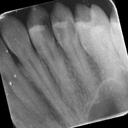
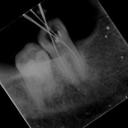
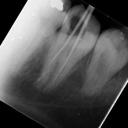
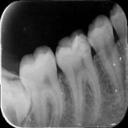
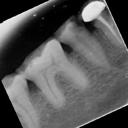
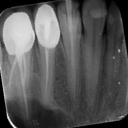

Training Epoch 80/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 80: Average Training Loss: 0.10524915199240913


Validation Epoch 80/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 80: Average Validation Loss: 0.292151094340592



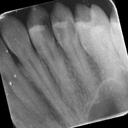
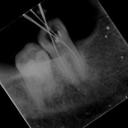
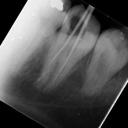
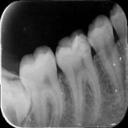
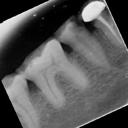
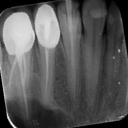

Training Epoch 81/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 81: Average Training Loss: 0.10369007546246423


Validation Epoch 81/100: 100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch 81: Average Validation Loss: 0.297003562783273



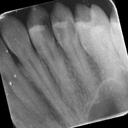
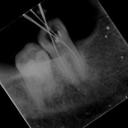
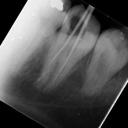
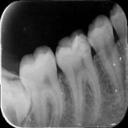
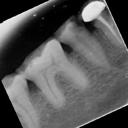
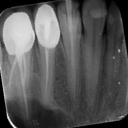

Training Epoch 82/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 82: Average Training Loss: 0.10220763244614098


Validation Epoch 82/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 82: Average Validation Loss: 0.30283029736589184



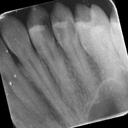
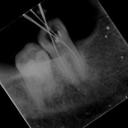
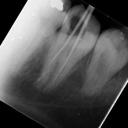
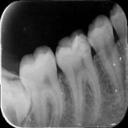
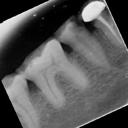
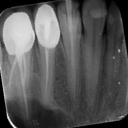

Training Epoch 83/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 83: Average Training Loss: 0.10285959067690817


Validation Epoch 83/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 83: Average Validation Loss: 0.3009071826211197



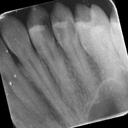
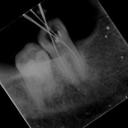
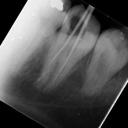
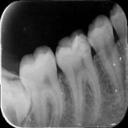
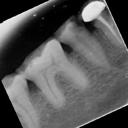
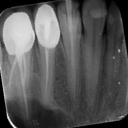

Training Epoch 84/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 84: Average Training Loss: 0.09968651392676445


Validation Epoch 84/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 84: Average Validation Loss: 0.29930351977404074



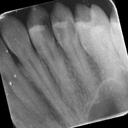
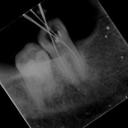
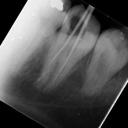
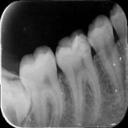
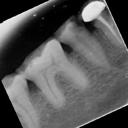
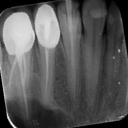

Training Epoch 85/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 85: Average Training Loss: 0.09512760020468546


Validation Epoch 85/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 85: Average Validation Loss: 0.302565011175738



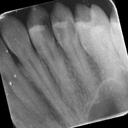
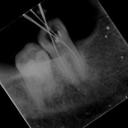
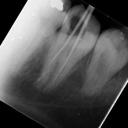
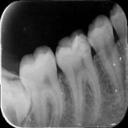
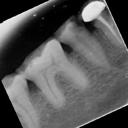
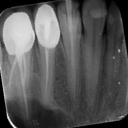

Training Epoch 86/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 86: Average Training Loss: 0.09418967333824738


Validation Epoch 86/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 86: Average Validation Loss: 0.29780406691133976



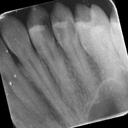
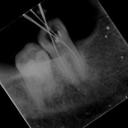
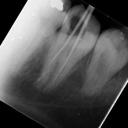
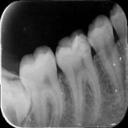
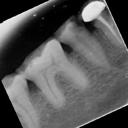
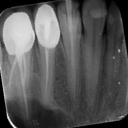

Training Epoch 87/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 87: Average Training Loss: 0.09194236419956137


Validation Epoch 87/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 87: Average Validation Loss: 0.30052056994369564



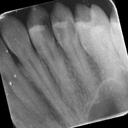
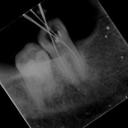
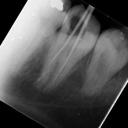
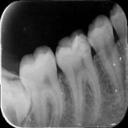
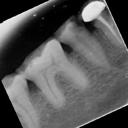
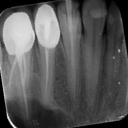

Training Epoch 88/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 88: Average Training Loss: 0.09314447750123392


Validation Epoch 88/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 88: Average Validation Loss: 0.30673710778087593



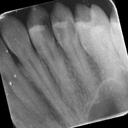
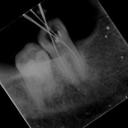
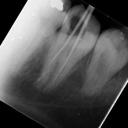
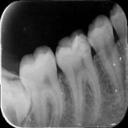
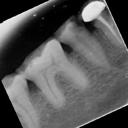
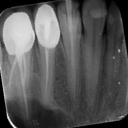

Training Epoch 89/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 89: Average Training Loss: 0.09487578902185334


Validation Epoch 89/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 89: Average Validation Loss: 0.3067520134311786



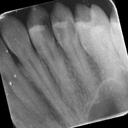
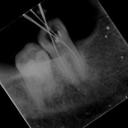
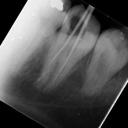
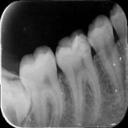
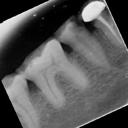
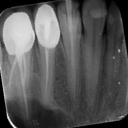

Training Epoch 90/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 90: Average Training Loss: 0.09166631104875796


Validation Epoch 90/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 90: Average Validation Loss: 0.3037452375878104



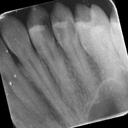
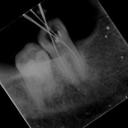
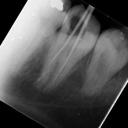
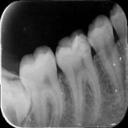
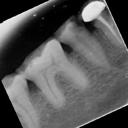
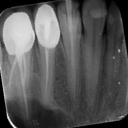

Training Epoch 91/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 91: Average Training Loss: 0.08932842583806248


Validation Epoch 91/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 91: Average Validation Loss: 0.30264538753000525



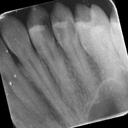
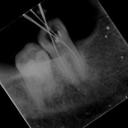
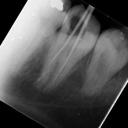
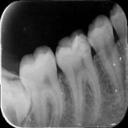
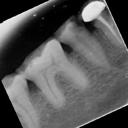
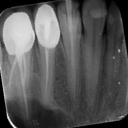

Training Epoch 92/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 92: Average Training Loss: 0.09021306028647452


Validation Epoch 92/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 92: Average Validation Loss: 0.29691477873020894



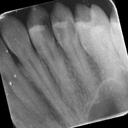
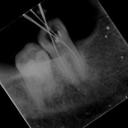
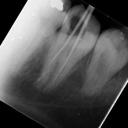
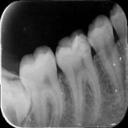
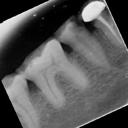
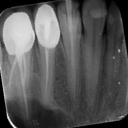

Training Epoch 93/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 93: Average Training Loss: 0.08758942234497633


Validation Epoch 93/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 93: Average Validation Loss: 0.298817374777022



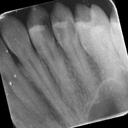
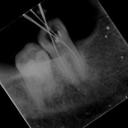
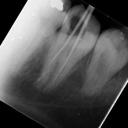
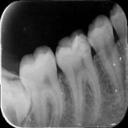
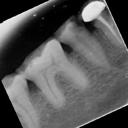
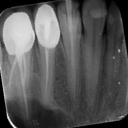

Training Epoch 94/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 94: Average Training Loss: 0.0873968891961419


Validation Epoch 94/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 94: Average Validation Loss: 0.29759867593860456



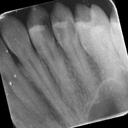
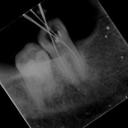
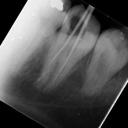
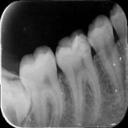
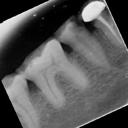
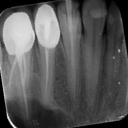

Training Epoch 95/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 95: Average Training Loss: 0.08691020336534296


Validation Epoch 95/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 95: Average Validation Loss: 0.2998452264976373



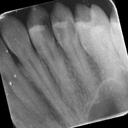
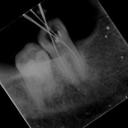
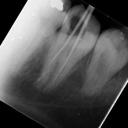
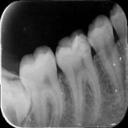
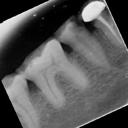
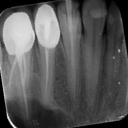

Training Epoch 96/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 96: Average Training Loss: 0.08551592377494581


Validation Epoch 96/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 96: Average Validation Loss: 0.29926813011921993



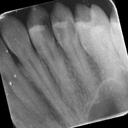
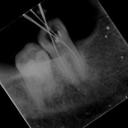
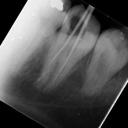
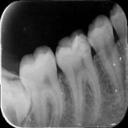
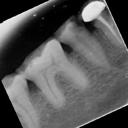
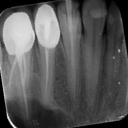

Training Epoch 97/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 97: Average Training Loss: 0.08363812273333532


Validation Epoch 97/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 97: Average Validation Loss: 0.2986179886640405



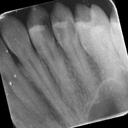
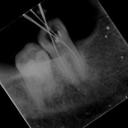
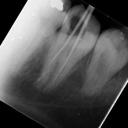
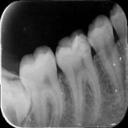
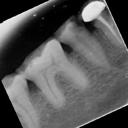
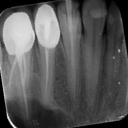

Training Epoch 98/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 98: Average Training Loss: 0.08208648211421063


Validation Epoch 98/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 98: Average Validation Loss: 0.2992981635570097



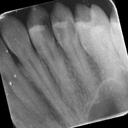
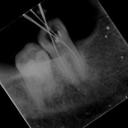
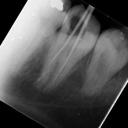
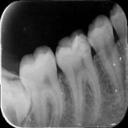
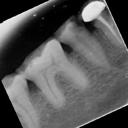
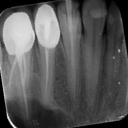

Training Epoch 99/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 99: Average Training Loss: 0.08263820832051476


Validation Epoch 99/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 99: Average Validation Loss: 0.2995096412520829



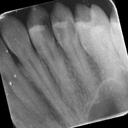
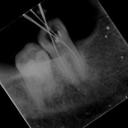
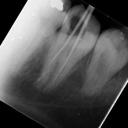
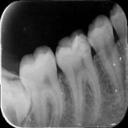
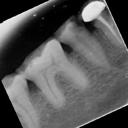
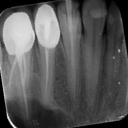

Training Epoch 100/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 100: Average Training Loss: 0.08196572745392411


Validation Epoch 100/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 100: Average Validation Loss: 0.2997174085446184



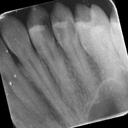
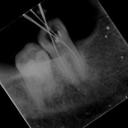
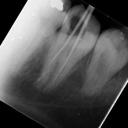
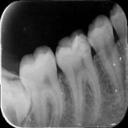
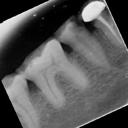
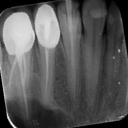

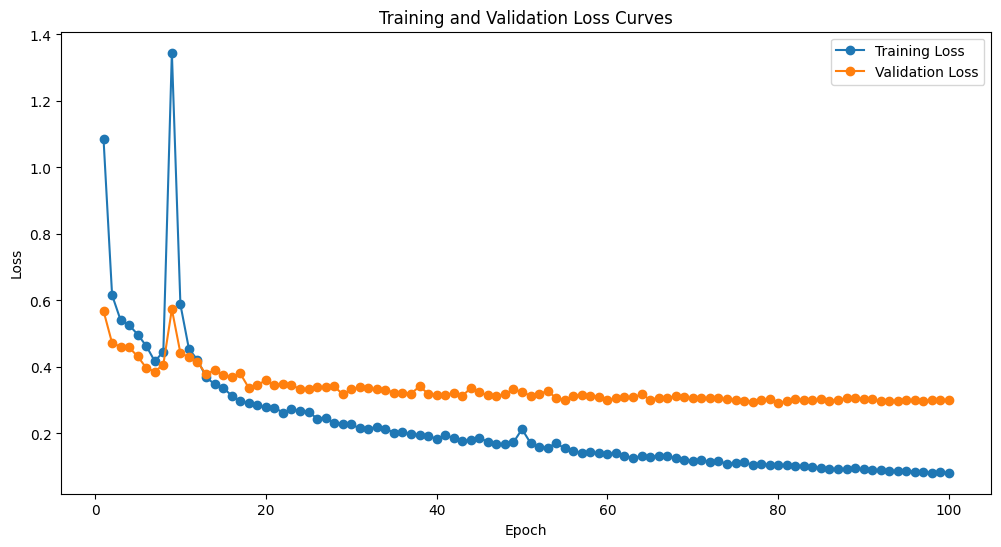

In [14]:
# Example usage
train_model(train_loader, val_loader, peft_model, processor, epochs=100, lr=1e-3)

In [15]:
"""import os
import torch
from transformers import AutoProcessor

# Specify the directory where the best model and processor were saved
output_dir = "/kaggle/working/model_checkpoints/best_model_epoch_3"

# Check if the directory exists
if not os.path.exists(output_dir):
    raise FileNotFoundError(f"The directory {output_dir} does not exist. Please check the path.")

# Reload the best model state dict
model = peft_model  # Ensure to define or import the correct model architecture used during training
model_path = os.path.join(output_dir, "model.pth")
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()  # Set the model to evaluation mode


print(f"Successfully reloaded the best model and processor from best epoch.")
"""

'import os\nimport torch\nfrom transformers import AutoProcessor\n\n# Specify the directory where the best model and processor were saved\noutput_dir = "/kaggle/working/model_checkpoints/best_model_epoch_3"\n\n# Check if the directory exists\nif not os.path.exists(output_dir):\n    raise FileNotFoundError(f"The directory {output_dir} does not exist. Please check the path.")\n\n# Reload the best model state dict\nmodel = peft_model  # Ensure to define or import the correct model architecture used during training\nmodel_path = os.path.join(output_dir, "model.pth")\nmodel.load_state_dict(torch.load(model_path))\nmodel.to(DEVICE)\nmodel.eval()  # Set the model to evaluation mode\n\n\nprint(f"Successfully reloaded the best model and processor from best epoch.")\n'


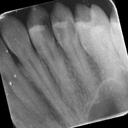
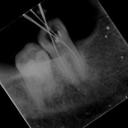
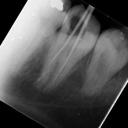
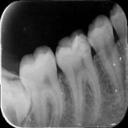
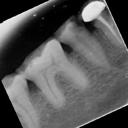
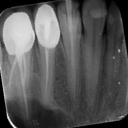
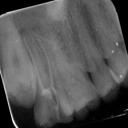
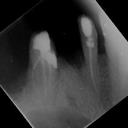
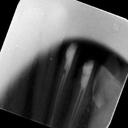
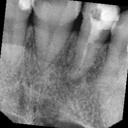
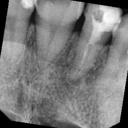
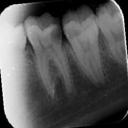
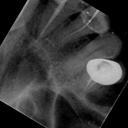
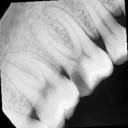
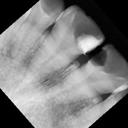
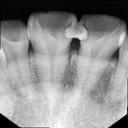
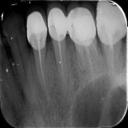
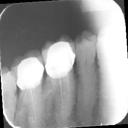
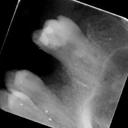
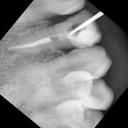
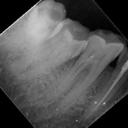
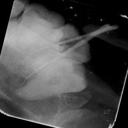
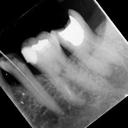
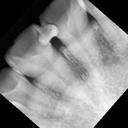
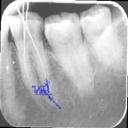
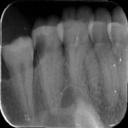
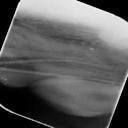
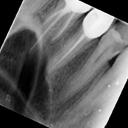
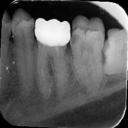
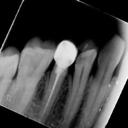
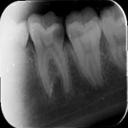
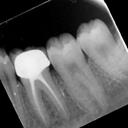
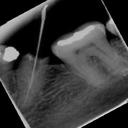
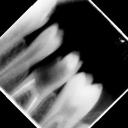
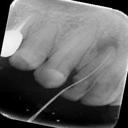
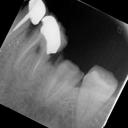
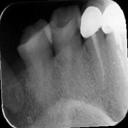
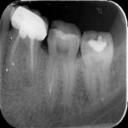
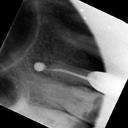
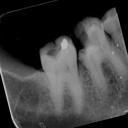
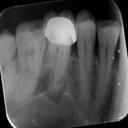
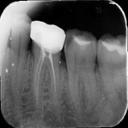
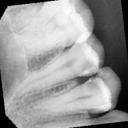
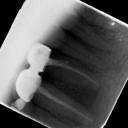
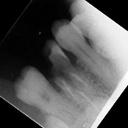
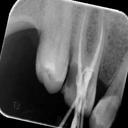
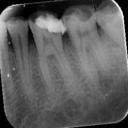
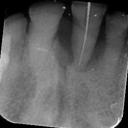
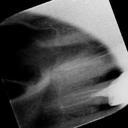
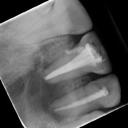
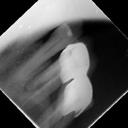
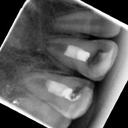
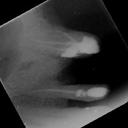
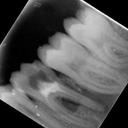
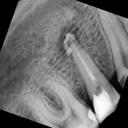
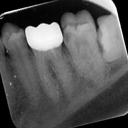
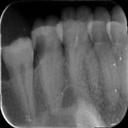
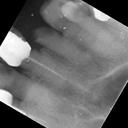
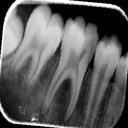
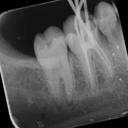
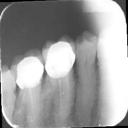
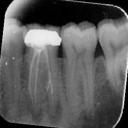
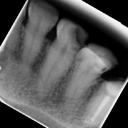
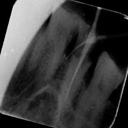
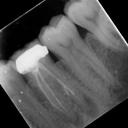
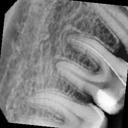
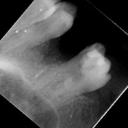
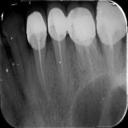
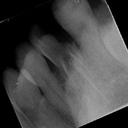
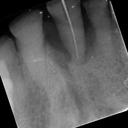
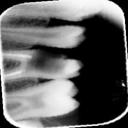
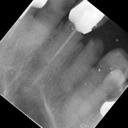
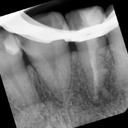
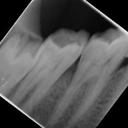
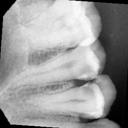
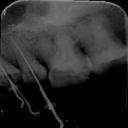
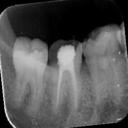
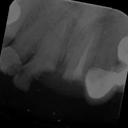
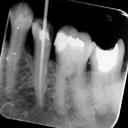
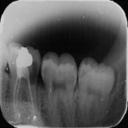
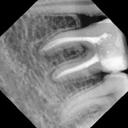
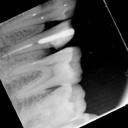
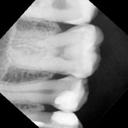
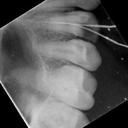
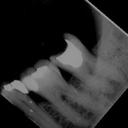
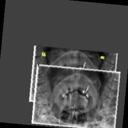
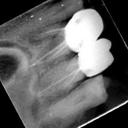
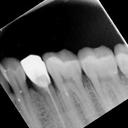
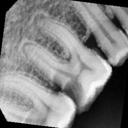
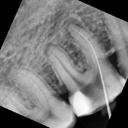
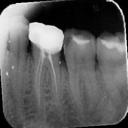
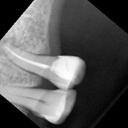
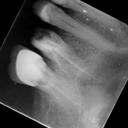
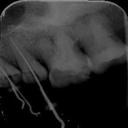
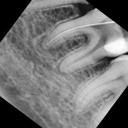
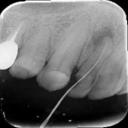
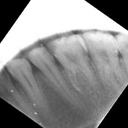
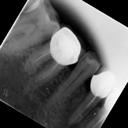
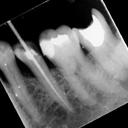
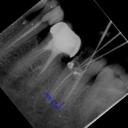
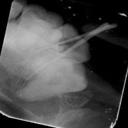
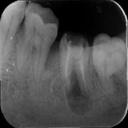
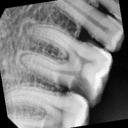
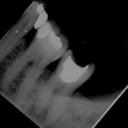
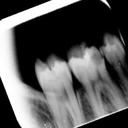
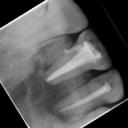
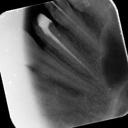
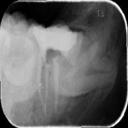
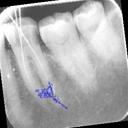
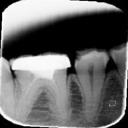
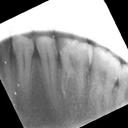
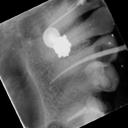
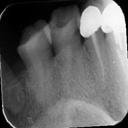
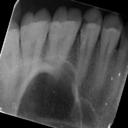
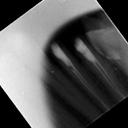
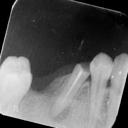
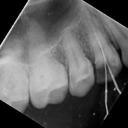
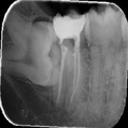
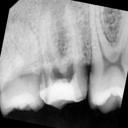
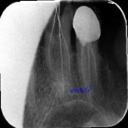
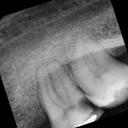
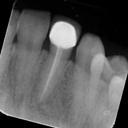
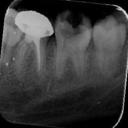
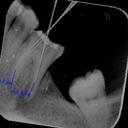
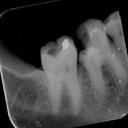
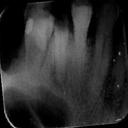
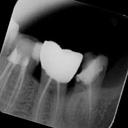
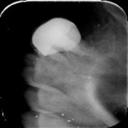
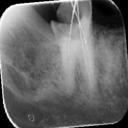
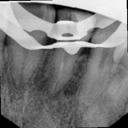
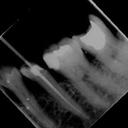
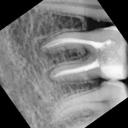
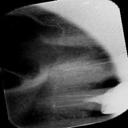
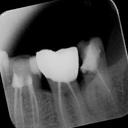
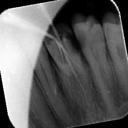
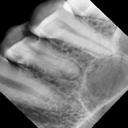
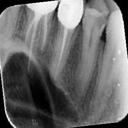
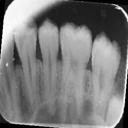
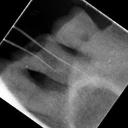

In [16]:
# Render inference results for validation data
render_inference_results(peft_model, val_loader.dataset, 139)

Inference: 100%|██████████| 139/139 [03:32<00:00,  1.53s/it]


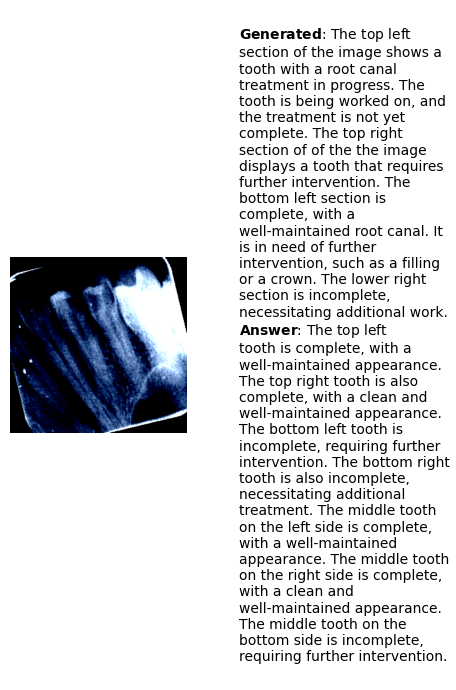

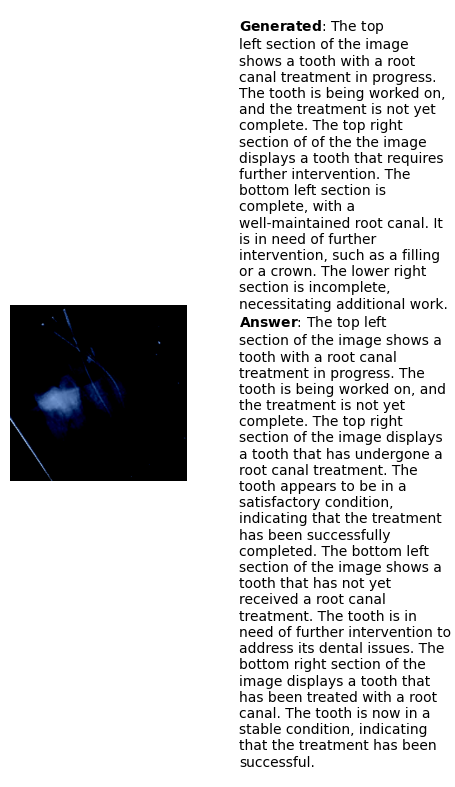

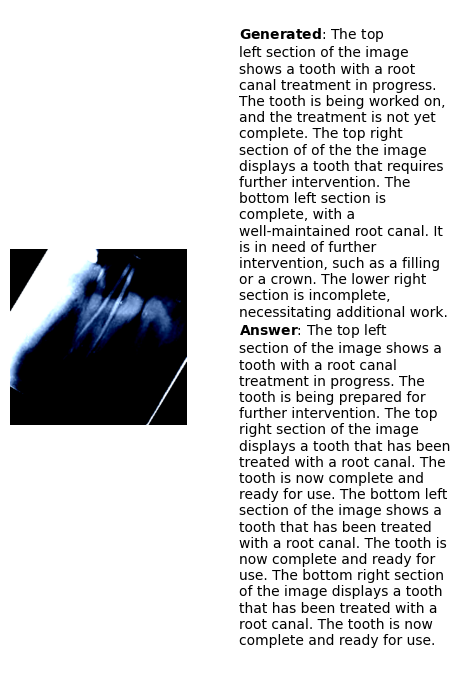

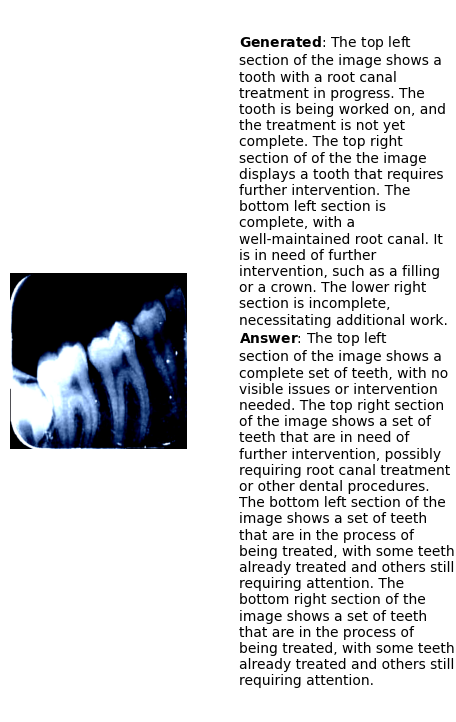

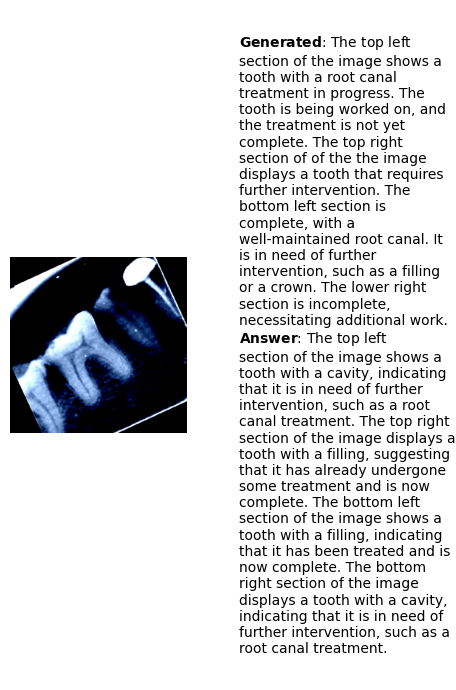

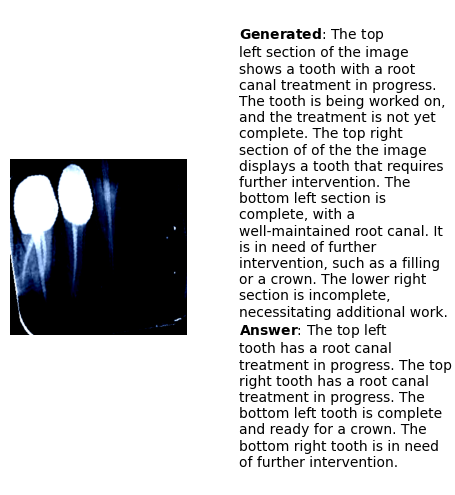

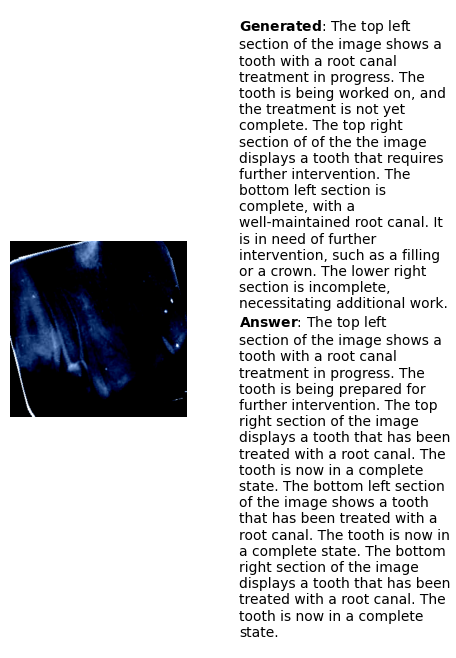

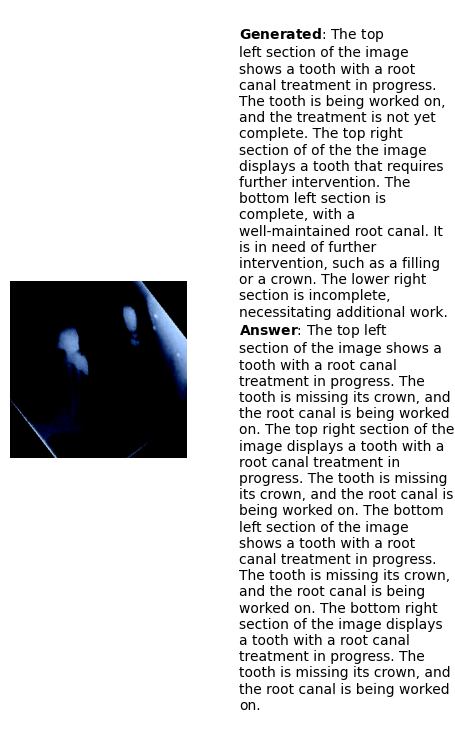

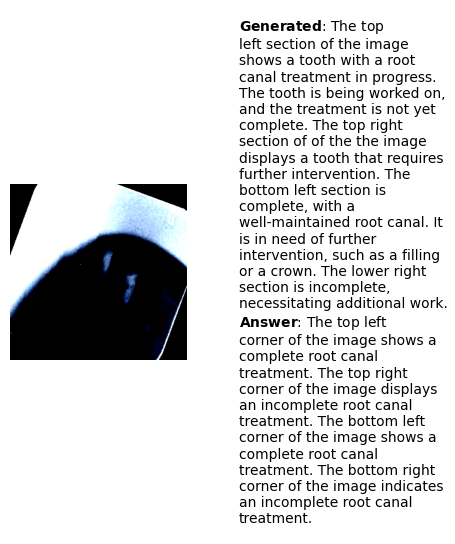

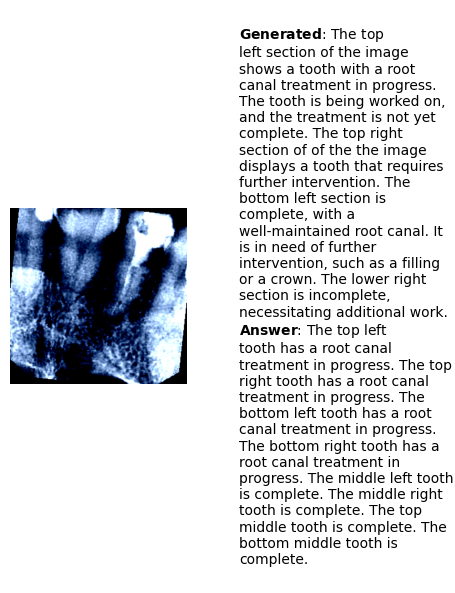

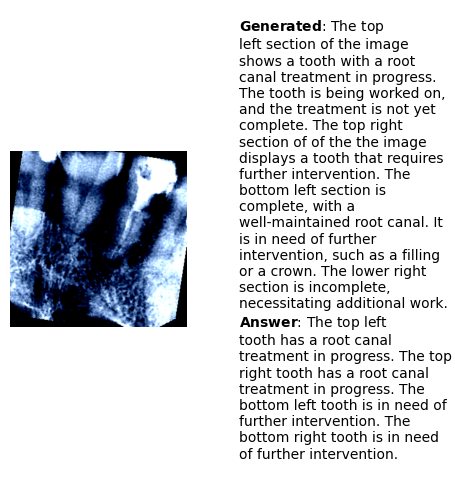

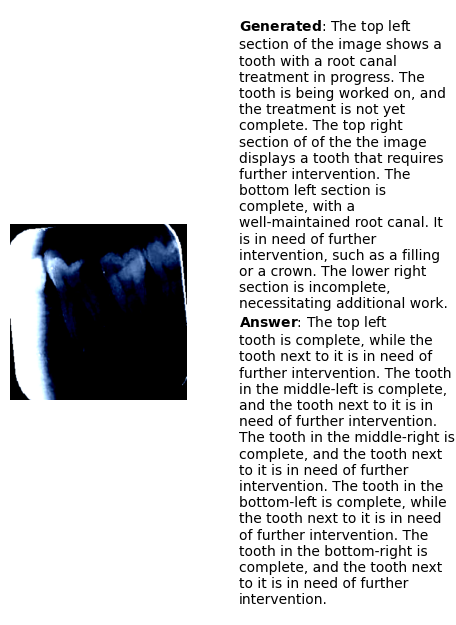

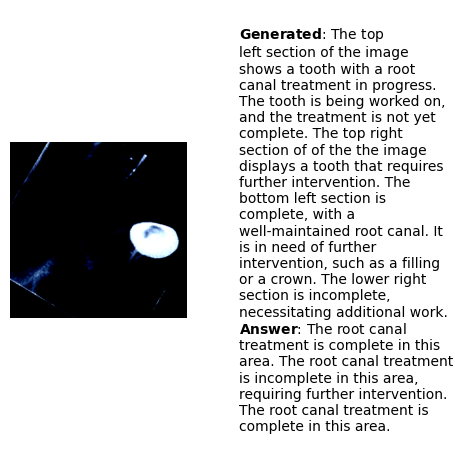

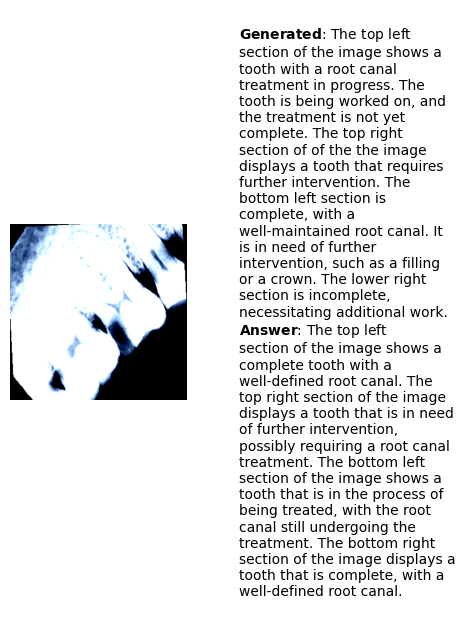

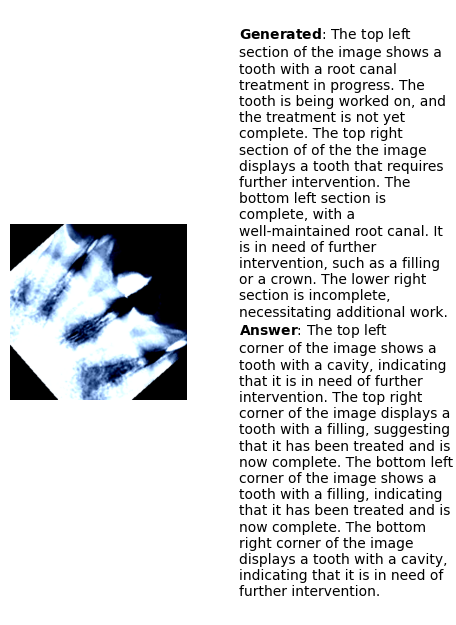

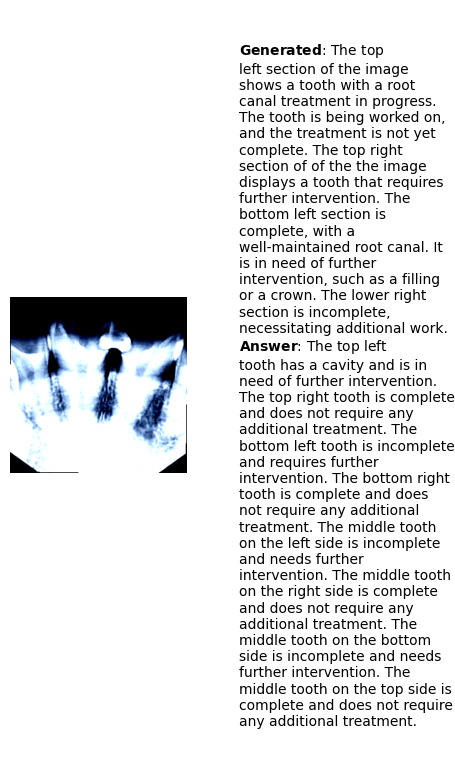

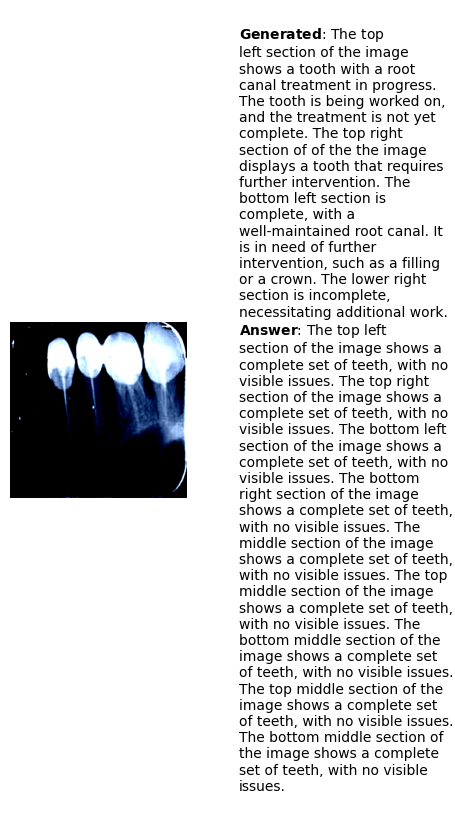

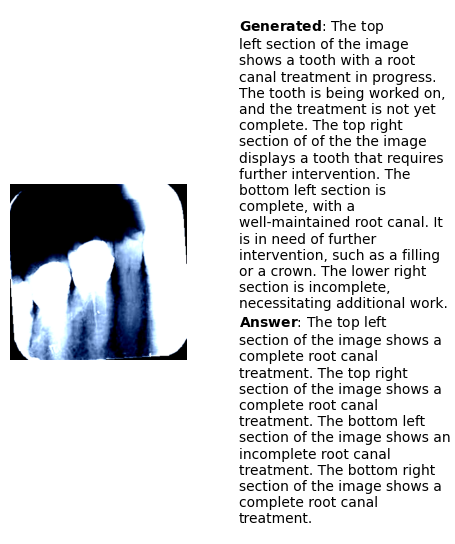

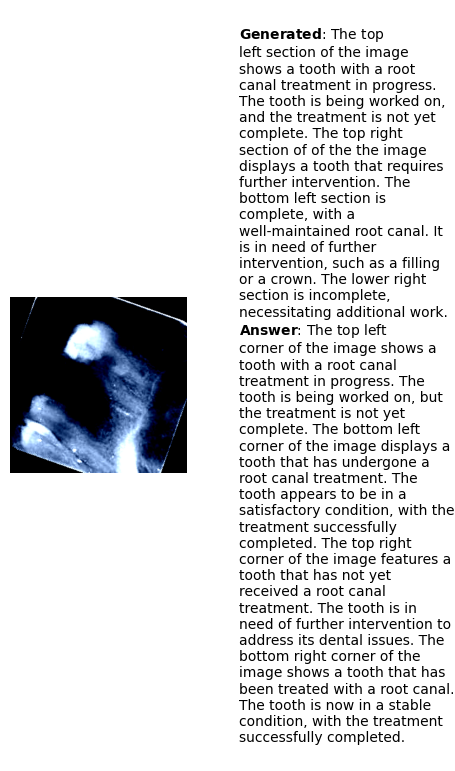

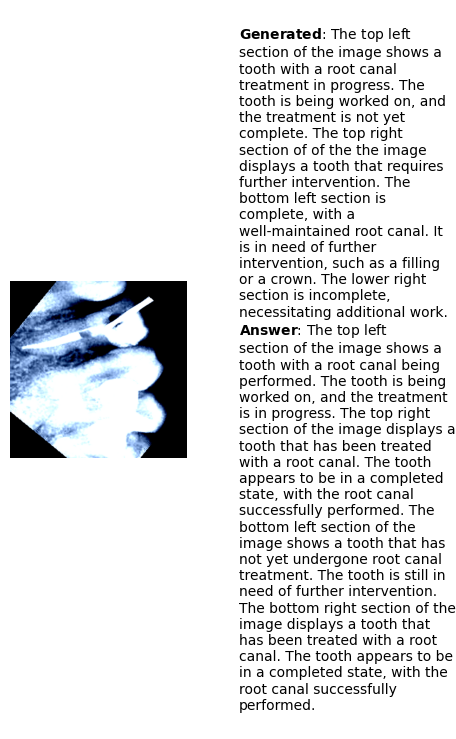

In [17]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def run_inference(model, processor, data_loader, device):
    model.eval()
    results = []

    for inputs, answers in tqdm(data_loader, desc="Inference"):
        # Move tensors to device
        inputs = {
            key: value.to(device) if key != 'input_ids' else value.to(device).long()
            for key, value in inputs.items()
        }
        # Prepare decoder input ids
        decoder_input_ids = torch.full((inputs['input_ids'].shape[0], 1), processor.tokenizer.bos_token_id, dtype=torch.long, device=device)

        with torch.no_grad():
            # Generate captions
            generated_ids = model.generate(
                input_ids=inputs['input_ids'],
                pixel_values=inputs['pixel_values'],
                max_new_tokens=1024,
                num_beams=3
            )

        # Decode generated IDs to text
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

        # Collect results
        for pred, ans, img in zip(generated_texts, answers, inputs['pixel_values']):
            img = img.cpu().permute(1, 2, 0)  # Ensure image is in HWC format for display
            img = img.numpy()  # Convert tensor to numpy array
            results.append({'prediction': pred, 'answer': ans, 'image': img})

    return results

# Run inference on the validation dataset
val_results = run_inference(peft_model, processor, val_loader, DEVICE)

# Display answers and generated captions
for i, result in enumerate(val_results[:20]):
    plt.figure(figsize=(5, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(result['image'])
    plt.axis('off')
    plt.title(f"")

    # Display the generated caption
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, f"$\\bf{{Generated}}$: {result['prediction']}\n$\\bf{{Answer}}$: {result['answer']}",
             fontsize=10, ha='left', va='center', wrap=True)
    plt.axis('off')
    plt.title(f"")

    plt.show()


In [18]:
# Install all required packages
!pip install scikit-learn rouge-score git+https://github.com/salaniz/pycocoevalcap.git

# Download necessary NLTK data packages for BLEU and METEOR scores
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import pycocoevalcap.bleu.bleu
import pycocoevalcap.meteor.meteor
import pycocoevalcap.cider.cider

# Prepare your predictions and references
predictions = [result['prediction'] for result in val_results]
references = [result['answer'] for result in val_results]

# Convert lists to dictionaries with image IDs as keys
gts = {i: [ref] for i, ref in enumerate(references)}
res = {i: [pred] for i, pred in enumerate(predictions)}

# Evaluate using BLEU Score
bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4
bleu_score, _ = bleu_scorer.compute_score(gts, res)
print(f"BLEU Score: {bleu_score}")

# Evaluate using METEOR Score (from pycocoevalcap)
meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()
meteor_score, _ = meteor_scorer.compute_score(gts, res)
print(f"METEOR Score: {meteor_score}")

# Evaluate using ROUGE Score
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(references)

for i in gts:
    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples

print(f"ROUGE Scores: {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = pycocoevalcap.cider.cider.Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"CIDEr Score: {cider_score}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-jta44e0s
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-jta44e0s
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 18.8 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ba379d2f381b5583bffcdd66b41af4e1efe09d86b2c075f3881ae24840b2b8fb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=b0b10c9d0e84d939543b11435bb9ea0aaa1317ddb55fbd5950d1c6e17b2ea556
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ratcp4o/wheels/57/de/9f/7aa9

In [19]:
# Install all required packages
!pip install scikit-learn rouge-score git+https://github.com/salaniz/pycocoevalcap.git autocorrect gensim

# Download necessary NLTK data packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from autocorrect import Speller
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag
from collections import Counter
import pycocoevalcap.bleu.bleu
import pycocoevalcap.meteor.meteor
import pycocoevalcap.cider.cider
from rouge_score import rouge_scorer
import re
import string

# Initialize spell checker, stemmer, and stop words
spell = Speller()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to perform spell correction
def correct_spelling(text):
    return spell(text)

# Function to expand common contractions
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"
}

def expand_contractions(text):
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    return text

# Function for POS filtering to retain meaningful words
def filter_pos(tokens):
    allowed_tags = {'NN', 'VB', 'JJ'}
    return [word for word, tag in pos_tag(tokens) if tag[:2] in allowed_tags]

# Function to remove low-frequency words based on a dataset-wide frequency count
def remove_low_frequency_words(tokens, frequency_dict, threshold=2):
    return [word for word in tokens if frequency_dict[word] > threshold]

# Preprocessing function with advanced techniques
def preprocess_text(text, frequency_dict):
    # Correct spelling errors
    text = correct_spelling(text)
    
    # Lowercase the text
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stop words
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    
    # POS filtering to retain nouns, verbs, adjectives
    tokens = filter_pos(tokens)

    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove low-frequency words
    tokens = remove_low_frequency_words(tokens, frequency_dict)

    return ' '.join(tokens).strip()

# Build a frequency dictionary from your dataset
def build_frequency_dict(texts):
    all_words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        all_words.extend([word for word in tokens if word.isalpha()])
    return Counter(all_words)

# Prepare your predictions and references
predictions = [result['prediction'] for result in val_results]
references = [result['answer'] for result in val_results]

# Build frequency dictionary for low-frequency word removal
all_captions = predictions + references
frequency_dict = build_frequency_dict(all_captions)

# Preprocess predictions and references
preprocessed_predictions = [preprocess_text(pred, frequency_dict) for pred in predictions]
preprocessed_references = [preprocess_text(ref, frequency_dict) for ref in references]

# Convert lists to dictionaries with image IDs as keys
gts = {i: [ref] for i, ref in enumerate(preprocessed_references)}
res = {i: [pred] for i, pred in enumerate(preprocessed_predictions)}

# Evaluate using BLEU Score
bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4
bleu_score, _ = bleu_scorer.compute_score(gts, res)
print(f"BLEU Score: {bleu_score}")

# Evaluate using METEOR Score
meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()
meteor_score, _ = meteor_scorer.compute_score(gts, res)
print(f"METEOR Score: {meteor_score}")

# Evaluate using ROUGE Score
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(preprocessed_references)

for i in gts:
    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples

print(f"ROUGE Scores: {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = pycocoevalcap.cider.cider.Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"CIDEr Score: {cider_score}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-5n2h41pc
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-5n2h41pc
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 36.6 MB/s eta 0:00:00
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=ad61f5959159578aa4d04f6bd2bcc5689bd4a3fb6947edf0186e34174978368f
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
  Attempting uninstall: scipy
    Found existing insta